# Tranfer Learning

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = models.vgg16(pretrained=True).to(device)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/maukanmir/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 51.4MB/s] 


In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [5]:
training_path = "/Users/maukanmir/Downloads/Archive/training_set/training_set"
test_path = "/Users/maukanmir/Downloads/Archive/test_set/test_set"

In [7]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 
                   0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); 
        shuffle(self.fpaths)
        self.targets =[fpath.split('/')[-1].startswith('dog') \
                        for fpath in self.fpaths] 
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [8]:
data = CatsDogs(training_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.])


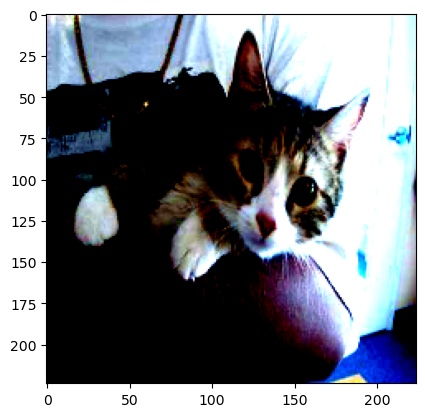

In [9]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [11]:

def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [12]:
model, criterion, optimizer = get_model()

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train = CatsDogs(training_path)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_path)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [14]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:

train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


## Understanding ResNet architecture

### While building too deep a network, there are two problems. In forward propagation, the last few layers of the network have almost no information about what the original image was. In backpropagation, the first few layers near the input hardly get any gradient updates due to vanishing gradients (in other words, they are almost zero). To solve both problems, residual networks (ResNet) use a highway-like connection that transfers raw information from the previous few layers to the later layers. In theory, even the last layer will have the entire information of the original image due to this highway network. And because of the skipping layers, the backward gradients will flow freely to the initial layers with little modification.

### The term residual in the residual network is the additional information that the model is expected to learn from the previous layer that needs to be passed on to the next layer.

### As you can see, while so far, we have been interested in extracting the F(x) value, where x is the value coming from the previous layer, in the case of a residual network, we are extracting not only the value after passing through the weight layers, which is F(x), but are also summing up F(x) with the original value, which is x.



## Example of Image Pipeline in PyTorch

In [ ]:
from torchvision import transforms as T

trn_tfms = T.Compose([
                T.ToPILImage(),
                T.Resize(128),
                T.CenterCrop(128),
                T.ColorJitter(brightness=(0.95,1.05), 
                              contrast=(0.95,1.05), 
                              saturation=(0.95,1.05), 
                              hue=0.05),
                T.RandomAffine(5, translate=(0.01,0.1)),
                T.ToTensor(),
                T.Normalize(mean=[0.5, 0.5, 0.5], 
                            std=[0.5, 0.5, 0.5]),
            ])

### In the preceding code, we have a pipeline of transformations on top of the input image – which is a pipeline of resizing the image (which ensures that the minimum size of one of the dimensions is 128, in this case) and then cropping it from the center. Furthermore, we are performing random color jittering and affine transformation. Next, we are scaling an image using the .ToTensor method to have a value between 0 and 1, and finally, we are normalizing the image. As discussed in Chapter 4, Introducing Convolutional Neural Networks, we can also use the imgaug library.